# Anomaly Detection using Adtk(Integration with sktime)
Data Source - NAB Benchmark [NYC Taxi Data](https://github.com/numenta/NAB.git)

In [1]:
!git clone https://github.com/numenta/NAB.git

Cloning into 'NAB'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 6928 (delta 5), reused 7 (delta 3), pack-reused 6915
Receiving objects: 100% (6928/6928), 83.23 MiB | 24.48 MiB/s, done.
Resolving deltas: 100% (4879/4879), done.
Checking out files: 100% (1119/1119), done.


In [2]:
%ls NAB/data/realKnownCause/nyc_taxi.csv

NAB/data/realKnownCause/nyc_taxi.csv


In [3]:
!pip install sktime

     |████████████████████████████████| 5.7MB 4.2MB/s 
     |████████████████████████████████| 9.5MB 35.5MB/s 
     |████████████████████████████████| 22.3MB 118kB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [4]:
!pip install adtk

     |████████████████████████████████| 61kB 3.3MB/s 


In [5]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 5.4MB/s 
     |████████████████████████████████| 2.1MB 21.1MB/s 
  Found existing installation: Cython 0.29.22
    Uninstalling Cython-0.29.22:
      Successfully uninstalled Cython-0.29.22


In [6]:
import pandas as  pd
from sklearn.ensemble import IsolationForest

from sktime.forecasting.model_selection import SlidingWindowSplitter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.metrics import pairwise_distances

from adtk.aggregator import AndAggregator
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [8]:
import sktime
from adtk.detector import OutlierDetector
from adtk.transformer import CustomizedTransformerHD
from adtk.pipe import Pipenet

from sktime.transformations.series.impute import Imputer
from sktime.forecasting.arima import AutoARIMA

from sktime.forecasting.compose import (
    TransformedTargetForecaster
)

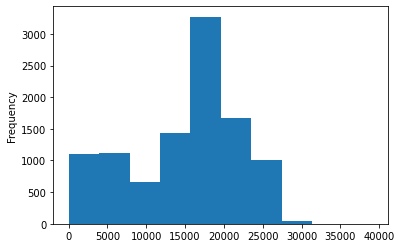

In [9]:
df = pd.read_csv("NAB/data/realKnownCause/nyc_taxi.csv",parse_dates=["timestamp"],index_col="timestamp")
df["value"].plot(kind="hist")

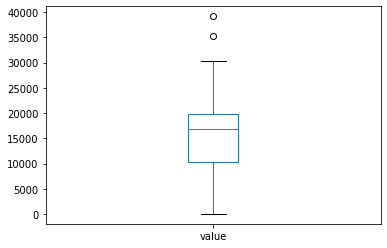

In [10]:
df["value"].plot(kind="box")

In [11]:
#df["hour"] = df.index.hour
#df["minute"] = df.index.minute
#df["dayofweek"] = df.index.dayofweek
#df["month"] = df.index.month

In [12]:
#df.head()

## Isolation Forest(Univariate Data)

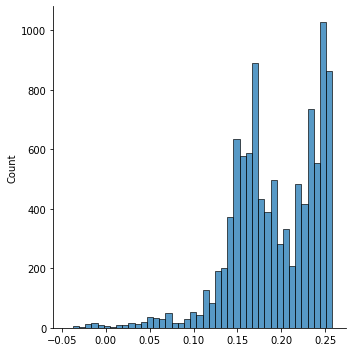

In [13]:
iso_forest = IsolationForest(contamination=0.005,random_state=0)
iso_forest.fit(df[['value']].values)
sns.displot(iso_forest.decision_function(df[['value']].values))

In [14]:
df['anomaly_scores'] = iso_forest.decision_function(df[['value']].values)
df['anomaly'] = 1
df.loc[df['anomaly_scores']<-0.03,'anomaly'] = -1

In [15]:
layout = go.Layout(plot_bgcolor='#F0E9E6')
fig = go.Figure(layout=layout)

fig.add_trace(
    go.Scatter(
    x=df.index,
    y=df['value'],
    line=dict(color='#7A95BB', width=2),
    mode='lines',
    name='Taxi Bookings'
    )
)
fig.add_trace(
    go.Scatter(
    x=df.loc[df['anomaly']==-1].index,
    y=df.loc[df['anomaly']==-1]['value'],
    line=dict(color='#082255', width=2),
    mode='markers',
    name='Anomalies'
    )
)

fig.update_layout(
                   title='Taxi Data Anomaly Detection(Isolaion Forest)',
                   xaxis_title='Time',
                   yaxis_title='Taxi Books', 
                   xaxis_showgrid=False, 
                   yaxis_showgrid=False
)

fig.show()

In [22]:
#Use sktime Sliding Window splitter
#Create sliding windows of length 48 and steps of 48
cv = SlidingWindowSplitter(
            window_length=48, step_length=48, start_with_window=True
        )
cv

In [23]:
len([_[0] for _ in cv.split(df["value"])])

214

In [24]:
iforests_for_each_window = []

#Fit an Iforest for each sliding window as univariate data
for each_window in cv.split(df["value"]):
    iso_forest = IsolationForest(contamination=0.005,random_state=0)
    iso_forest.fit(df.iloc[each_window[0],:][["value"]])
    iforests_for_each_window.append(iso_forest)

In [25]:
df['anomaly'] = 0
for index,each_window in enumerate(cv.split(df["value"])):
    
    df.iloc[each_window[0],-1] = iforests_for_each_window[index].predict(df.iloc[each_window[0],:][["value"]])

In [26]:
#
#1 0.0 0.30 1.00 1.30
#   NO   NO  Yes  No

In [27]:
layout = go.Layout(plot_bgcolor='#F0E9E6')
fig = go.Figure(layout=layout)

fig.add_trace(
    go.Scatter(
    x=df.index,
    y=df['value'],
    line=dict(color='#7A95BB', width=2),
    mode='lines',
    name='Taxi Bookings'
    )
)
fig.add_trace(
    go.Scatter(
    x=df.loc[df['anomaly']==-1].index,
    y=df.loc[df['anomaly']==-1]['value'],
    line=dict(color='#082255', width=2),
    mode='markers',
    name='Anomalies'
    )
)

fig.update_layout(
                   title='Taxi Data Anomaly Detection(Isolation FOrest Windows of length-48)',
                   xaxis_title='Time',
                   yaxis_title='Taxi Books', 
                   xaxis_showgrid=False, 
                   yaxis_showgrid=False
)

fig.show()

## DBSCAN

In [28]:
#Data scaled to mean zero and unit variance

scaler = StandardScaler()
scaler.fit(df[['value']])
df['scaled_value'] = scaler.transform(df[['value']])

In [29]:
dbscan = DBSCAN()
df['anomaly_dbscan_based'] = dbscan.fit_predict(df[['scaled_value']])
df['anomaly_dbscan_based'].head()

timestamp
2014-07-01 00:00:00    0
2014-07-01 00:30:00    0
2014-07-01 01:00:00    0
2014-07-01 01:30:00    0
2014-07-01 02:00:00    0
Name: anomaly_dbscan_based, dtype: int64

In [19]:
df.head()

,value,anomaly_scores,anomaly,scaled_value,anomaly_dbscan_based
timestamp,,,,,
2014-07-01 00:00:00,10844,0.149364,1,-0.618745,0
2014-07-01 00:30:00,8127,0.142052,1,-1.010291,0
2014-07-01 01:00:00,6210,0.161874,1,-1.286549,0
2014-07-01 01:30:00,4656,0.184455,1,-1.510496,0
2014-07-01 02:00:00,3820,0.173068,1,-1.630971,0


In [20]:
layout = go.Layout(plot_bgcolor='#F0E9E6')
fig = go.Figure(layout=layout)

fig.add_trace(
    go.Scatter(
    x=df.index,
    y=df['value'],
    line=dict(color='#7A95BB', width=2),
    mode='lines',
    name='Taxi Bookings'
    )
)
fig.add_trace(
    go.Scatter(
    x=df.loc[df['anomaly_dbscan_based']==-1].index,
    y=df.loc[df['anomaly_dbscan_based']==-1]['value'],
    line=dict(color='#082255', width=2),
    mode='markers',
    name='Anomalies'
    )
)

fig.update_layout(
                   title='Taxi Data Anomaly Detection(DBSCAN)',
                   xaxis_title='Time',
                   yaxis_title='Taxi Books', 
                   xaxis_showgrid=False, 
                   yaxis_showgrid=False
)

fig.show()

In [30]:
dbscan_for_each_window = []

#Fit a DBSCAN to each window of length 48

for each_window in cv.split(df["value"]):
    dbscan = DBSCAN()
    dbscan.fit(df.iloc[each_window[0],:][['scaled_value']])
    dbscan_for_each_window.append(dbscan)

In [31]:
df['anomaly_dbscan_based'] = 0
for index,each_window in enumerate(cv.split(df["scaled_value"])):
    
    df.iloc[each_window[0],-1] = dbscan_for_each_window[index].fit_predict(df.iloc[each_window[0],:][["scaled_value"]])

In [32]:
layout = go.Layout(plot_bgcolor='#F0E9E6')
fig = go.Figure(layout=layout)

fig.add_trace(
    go.Scatter(
    x=df.index,
    y=df['value'],
    line=dict(color='#7A95BB', width=2),
    mode='lines',
    name='Taxi Bookings'
    )
)
fig.add_trace(
    go.Scatter(
    x=df.loc[df['anomaly_dbscan_based']==-1].index,
    y=df.loc[df['anomaly_dbscan_based']==-1]['value'],
    line=dict(color='#082255', width=2),
    mode='markers',
    name='Anomalies'
    )
)

fig.update_layout(
                   title='Taxi Data Anomaly Detection(DBSCAN - Sliding Window-48)',
                   xaxis_title='Time',
                   yaxis_title='Taxi Books', 
                   xaxis_showgrid=False, 
                   yaxis_showgrid=False
)

fig.show()

## **Create ADTK Pipeline combining Isolation forest and DBSCAN outputs using ANDAggregator.**

In [33]:



def scaler_transformation(df):
    scaler = StandardScaler()
    index = df.index
    return pd.DataFrame(scaler.fit_transform(df[["value"]]).flatten(),index=index)

standard_scaler_transformer = CustomizedTransformerHD(transform_func=scaler_transformation)


In [34]:

steps = {
    "iforest": {
        "model": OutlierDetector(IsolationForest(contamination=0.005,random_state=0)),
        "input": "original"
    },
    "scaler": {
        "model": standard_scaler_transformer,
        "input": "original"
    },

    "dbscan": {
        "model": OutlierDetector(DBSCAN()),
        "input": "scaler"
    },
    
    "and_aggreagtor_for_outliers": {
        "model": AndAggregator(),
        "input": ["iforest", "dbscan"]
    }
}
pipenet = Pipenet(steps)

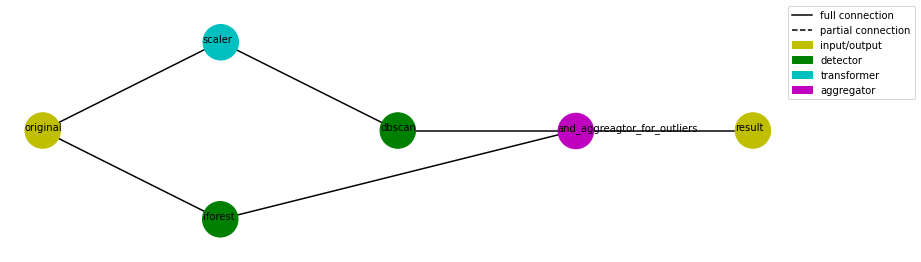

In [35]:
pipenet.plot_flowchart();

In [36]:
df["adtk_detect"] = pipenet.fit_detect(df[["value"]])
df.head()

,value,anomaly_scores,anomaly,scaled_value,anomaly_dbscan_based,adtk_detect
timestamp,,,,,,
2014-07-01 00:00:00,10844,0.149364,0,-0.618745,0,False
2014-07-01 00:30:00,8127,0.142052,0,-1.010291,0,False
2014-07-01 01:00:00,6210,0.161874,0,-1.286549,0,False
2014-07-01 01:30:00,4656,0.184455,0,-1.510496,0,False
2014-07-01 02:00:00,3820,0.173068,0,-1.630971,0,False


In [38]:
layout = go.Layout(plot_bgcolor='#F0E9E6')
fig = go.Figure(layout=layout)

fig.add_trace(
    go.Scatter(
    x=df.index,
    y=df['value'],
    line=dict(color='#7A95BB', width=2),
    mode='lines',
    name='Taxi Bookings'
    )
)
fig.add_trace(
    go.Scatter(
    x=df.loc[df['adtk_detect']==True].index,
    y=df.loc[df['adtk_detect']==True]['value'],
    line=dict(color='#082255', width=2),
    mode='markers',
    name='Anomalies'
    )
)

fig.update_layout(
                   title='Taxi Data Anomaly Detection(Pipleined using ADTK)',
                   xaxis_title='Time',
                   yaxis_title='Taxi Books', 
                   xaxis_showgrid=False, 
                   yaxis_showgrid=False
)

fig.show()

In [39]:
#Fill Outliers with Nans


df['value_anomaly_removed'] = df['value']
df.loc[df["adtk_detect"]==True,'value_anomaly_removed'] = np.nan

## Use Sktime Imputer to impute values.

In [ ]:
print("Number of Nans",df['value_anomaly_removed'].isna().sum())
#imputer_algo = AutoARIMA()

#Use sktime Imputer
imputer = Imputer(method="mean")
df.loc[:,'value_anomaly_removed'] = imputer.fit_transform(df['value_anomaly_removed'])
print("Number of Nans after imputing",df['value_anomaly_removed'].isna().sum())

Number of Nans 2
Number of Nans after imputing 0


In [40]:
layout = go.Layout(plot_bgcolor='#F0E9E6')
fig = go.Figure(layout=layout)

fig.add_trace(
    go.Scatter(
    x=df.index,
    y=df['value_anomaly_removed'],
    line=dict(color='#7A95BB', width=2),
    mode='lines',
    name='Taxi Bookings'
    )
)

fig.update_layout(
                   title='Taxi Data Anomaly Detection(Anomalies Removed)',
                   xaxis_title='Time',
                   yaxis_title='Taxi Books', 
                   xaxis_showgrid=False, 
                   yaxis_showgrid=False
)

fig.show()

## Anomaly Design Sketch(Integrate ADTK and Sktime)
Suggested By - **Markus Loning**<br>
```
class OutlierTransformer(_SeriesToSeriesTransformer):
  def __init__(self,adtk_pipenet):
    self.estimator = adtk_pipenet

  def fit(self, Z, y = None):
  
    self.estimator_ = self.estimator.fit()
    return self

  def transform(self, Z, y = None):

    #Code for transformation

    return transformed series
```